In [1]:
#my modules
import wrangle as wr
import explore as ex
import model as m

#Imports
import pandas as pd
import numpy as np

import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

imports loaded successfully, awaiting commands...


In [2]:
pd.set_option("display.max_colwidth", 250)

In [3]:
df = pd.read_parquet('df_prep.parquet')

In [4]:
df.company_response_to_consumer.value_counts()

Closed with explanation            982289
Closed with non-monetary relief    205284
Closed with monetary relief         50963
Untimely response                    4459
Closed                               3741
Name: company_response_to_consumer, dtype: int64

In [5]:
relief = ['Closed with monetary relief', 'Closed with non-monetary relief']
no_relief = ['Closed with explanation']
df = df[df['company_response_to_consumer'] != "Untimely response"]
df = df[df['company_response_to_consumer'] != "Closed"]

In [6]:
df['response'] = np.where(df['company_response_to_consumer'].isin(relief),'relief','')
df['response'] = np.where(df['company_response_to_consumer'].isin(no_relief),'no_relief',df['response'])

In [7]:
df = df.drop(columns='company_response_to_consumer')

In [8]:
df.response.value_counts(normalize=True)

no_relief    0.793105
relief       0.206895
Name: response, dtype: float64

In [9]:
baseline_accuracy = round(('no_relief' == df.response).mean(),4) * 100
print(f'Baseline Accuracy is {baseline_accuracy}%')

Baseline Accuracy is 79.31%


In [10]:
df.response.value_counts()

no_relief    982289
relief       256247
Name: response, dtype: int64

Specificity: When the actual value is negative, how often is the prediction correct?

* Something we want to maximize
* How "specific" (or "selective") is the classifier in predicting positive instances?
* TN / all negative
    * all negative = TN + FP
    
False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [11]:
# split
train, val, test = wr.split_data(df, 'response')

Prepared DF: (1238536, 8)
Train: (743121, 8)
Validate: (247707, 8)
Test: (247708, 8)


In [12]:
train.head(1)

,date_received,company_name,state,tags,product_bins,clean,lemon,response
274292,2019-09-09,Experian Information Solutions Inc.,FL,Servicemember,credit_report,i have been a victim of id theft and have submitted documentation to the credit bureaus and they are refusing to abide by fcra b pertaining to my request the original creditor has no proof other than statements and i have constantly refuted this ...,victim id theft submitted documentation credit bureau refusing abide fcra b pertaining request original creditor proof statement constantly refuted charge submitting proof id theft claim reporting complaint credit bureau consistent harm financial...,relief


In [14]:
# X_train, etc...
X_train, y_train, X_val, y_val, X_test, y_test = m.process_data_modeling2(train, val, test)

In [29]:
# vectorizing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, recall_score, average_precision_score, precision_score

import matplotlib as plt

In [17]:
# vectorize
X_train_tfe, X_val_tfe, X_test_tfe = m.process_vector_merge2(X_train,X_val,X_test)
X_train_tfe

,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage_x,abide,...,yet still,york,young,youre,youve,yr,zelle,zero,zero balance,zip
0,0,0,1,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,0,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148620,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148621,0,0,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148622,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148623,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# make
dt = DecisionTreeClassifier(random_state=123, max_depth=10, max_leaf_nodes=10)

# fit
dt.fit(X_train_tfe, y_train)

# use
dt_train = dt.score(X_train_tfe, y_train)
dt_val = dt.score(X_val_tfe, y_val)
print(f'Baseline Accuracy is {baseline_accuracy}%')
print(f"Train Accuracy: {dt_train:.3}%")
print(f"Validate Accuracy: {dt_val:.3}%")
print()

#predict
dt_pred_train = dt.predict(X_train_tfe)
dt_pred_val = dt.predict(X_val_tfe)

# recall score
r_score_train = recall_score(y_train, dt_pred_train, pos_label='no_relief')
r_score_val = recall_score(y_val, dt_pred_val, pos_label='no_relief')
print(f"Train recall score: {r_score_train:.3}%")
print(f"Validate recall score: {r_score_val:.3}%")

Baseline Accuracy is 79.31%
Train Accuracy: 0.795%
Validate Accuracy: 0.795%

Train recall score: 0.997%
Validate recall score: 0.996%


In [19]:
# classification report for train
round(pd.DataFrame(classification_report(y_train, dt_pred_train, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.796,0.646,0.795,0.721,0.765
recall,0.997,0.022,0.795,0.509,0.795
f1-score,0.885,0.043,0.795,0.464,0.711
support,117875.000,30750.000,0.795,148625.000,148625.000


In [20]:
# classification report for validate
round(pd.DataFrame(classification_report(y_val, dt_pred_val, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.796,0.619,0.795,0.707,0.759
recall,0.996,0.022,0.795,0.509,0.795
f1-score,0.885,0.043,0.795,0.464,0.711
support,39292.000,10250.000,0.795,49542.000,49542.000


In [31]:


    The loop then makes a list of lists of all max depth calculations, compares the
    accuracy between train and validate sets, turns to df, and adds a new column named
    difference. The function then calculates the baseline accuracy and plots the
    baseline, and the train and validate sets to identify where overfitting occurs.
    '''
    scores_all=[]

    for x in range(1,11):
        tree = DecisionTreeClassifier(max_depth=x, random_state=123)
        tree.fit(X_train, y_train)
        train_acc = tree.score(X_train, y_train)
        print(f"For depth of {x}, the train accuracy is {round(train_acc,3)}")
        
        # evaludate on validate set
        validate_acc = tree.score(X_validate, y_validate)
        print(f"For depth of {x}, the validate accuracy is {round(validate_acc,3)}")
        
        # recall score
        r_score_train = recall_score(y_train, dt_pred_train, pos_label='no_relief')
        r_score_val = recall_score(y_val, dt_pred_val, pos_label='no_relief')
        print(f"Train recall score: {r_score_train:.3}%")
        print(f"Validate recall score: {r_score_val:.3}%")
        print()

        # append to df scores_all
        scores_all.append([x, train_acc, validate_acc])

        # turn to df
        scores_df = pd.DataFrame(scores_all, columns=['max_depth', 'train_acc', 'validate_acc'])

        # make new column
        scores_df['difference'] = scores_df.train_acc - scores_df.validate_acc

        # sort on difference
        scores_df.sort_values('difference')


    # plot to visulaize
    plt.figure(figsize=(12,8))
    plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
    plt.plot(scores_df.max_depth, scores_df.validate_acc, label='validate', marker='o')
    plt.axhline(baseline_accuracy, linewidth=2, color='black', label='baseline')
    plt.xlabel('Max Depth for Decision Tree')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,11, step=1))
    plt.title('Where do I begin to overfit?')
    plt.legend()
    plt.show()

For depth of 1, the train accuracy is 0.793
For depth of 1, the validate accuracy is 0.793
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 2, the train accuracy is 0.793
For depth of 2, the validate accuracy is 0.793
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 3, the train accuracy is 0.795
For depth of 3, the validate accuracy is 0.795
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 4, the train accuracy is 0.796
For depth of 4, the validate accuracy is 0.795
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 5, the train accuracy is 0.798
For depth of 5, the validate accuracy is 0.795
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 6, the train accuracy is 0.8
For depth of 6, the validate accuracy is 0.797
Train recall score: 0.997%
Validate recall score: 0.996%

For depth of 7, the train accuracy is 0.802
For depth of 7, the validate accuracy is 0.797
Train recall scor

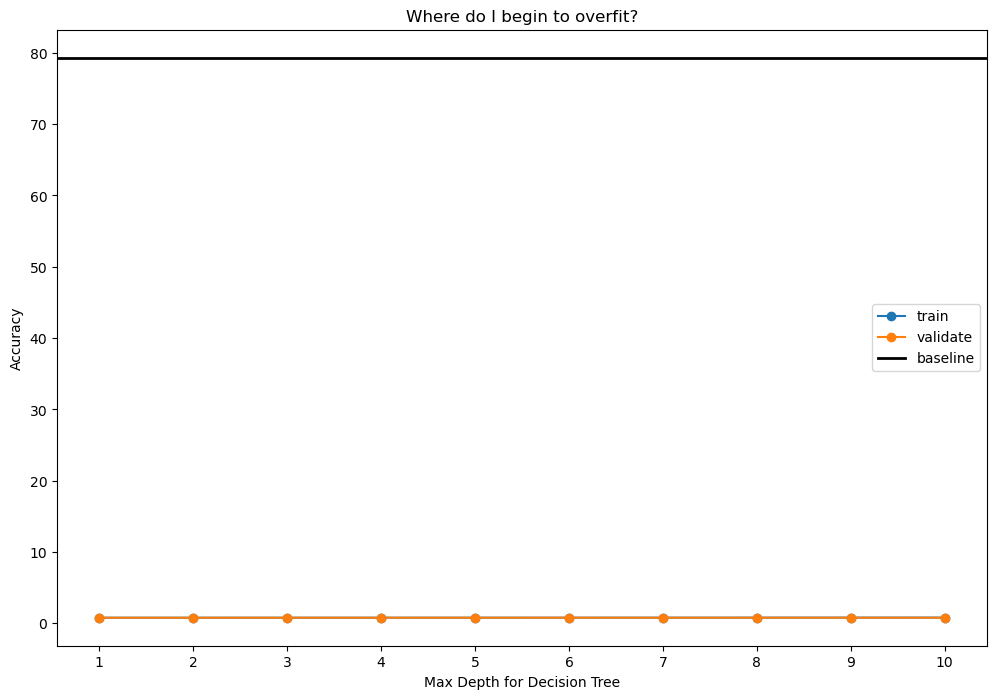

In [32]:
classifier_tree_eval(X_train_tfe, y_train, X_val_tfe, y_val, baseline_accuracy)

In [33]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plot 
import matplotlib as plt

In [34]:
# make
lr = LogisticRegression(random_state=123)

# fit model
lr.fit(X_train_tfe, y_train)

# use
lr_train = lr.score(X_train_tfe, y_train)
lr_val = lr.score(X_val_tfe, y_val)
print(f'Baseline Accuracy is {baseline_accuracy}%')
print(f"Train Accuracy: {lr_train:.3}%")
print(f"Validate Accuracy: {lr_val:.3}%")
print()

# predictions
y_pred_train = lr.predict(X_train_tfe)
y_pred_val = lr.predict(X_val_tfe)

# recall score
r_score_train = recall_score(y_train, y_pred_train, pos_label='no_relief')
r_score_val = recall_score(y_val, y_pred_val, pos_label='no_relief')
print(f"Train recall score: {r_score_train:.3}%")
print(f"Validate recall score: {r_score_val:.3}%")

Baseline Accuracy is 79.31%
Train Accuracy: 0.805%
Validate Accuracy: 0.798%

Train recall score: 0.977%
Validate recall score: 0.973%


In [35]:
# classification report for train
round(pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.814,0.624,0.805,0.719,0.775
recall,0.977,0.144,0.805,0.561,0.805
f1-score,0.888,0.234,0.805,0.561,0.753
support,117875.000,30750.000,0.805,148625.000,148625.000


In [36]:
# classification report for validate
round(pd.DataFrame(classification_report(y_val, y_pred_val, output_dict=True)),3)

,no_relief,relief,accuracy,macro avg,weighted avg
precision,0.810,0.553,0.798,0.681,0.757
recall,0.973,0.126,0.798,0.550,0.798
f1-score,0.884,0.206,0.798,0.545,0.744
support,39292.000,10250.000,0.798,49542.000,49542.000


AttributeError: module 'matplotlib' has no attribute 'show'

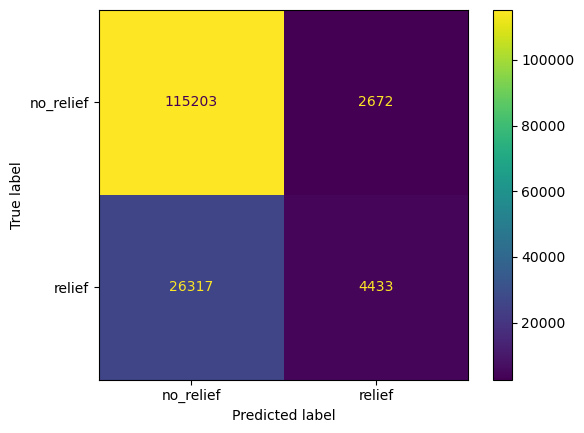

In [37]:
# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_train, labels=lr.classes_), display_labels=lr.classes_).plot()
plt.show()

minimizing damage by looking at additional metrics on top of accuracy baseline which is an average. Slightly improved on baseline but where we really saw the benefit was looking at the recall score which states predicts relief - no relief given.

98% good at catching false negatives. The times that isn't relieved results in 98% catch of this error which means, happier consumers, happier businesses.


In [41]:
df.shape

(1238536, 8)

In [43]:
df.response

0             relief
1             relief
2          no_relief
3          no_relief
4          no_relief
             ...    
1246731    no_relief
1246732    no_relief
1246733       relief
1246734    no_relief
1246735    no_relief
Name: response, Length: 1238536, dtype: object